In [93]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 7)

data = pd.read_csv('data/toy_regression.csv')

def plot3Dscatter(data, xcol, ycol, mdl, actual):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D


    # plot the plane of best fit
    # not as useful as one would like!

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x_surf = np.arange(data[xcol].min() - 1, data[xcol].max() + 1)
    y_surf = np.arange(data[ycol].min() - 1, data[ycol].max() + 1)
    #x_surf = np.arange(50, 80, 5)                # generate a mesh
    #y_surf = np.arange(50, 80, 5)
    x_surf, y_surf = np.meshgrid(x_surf, y_surf)

    zgrid = pd.core.frame.DataFrame(
        {xcol: x_surf.ravel(), ycol: y_surf.ravel()}
    )

    out = mdl.predict(zgrid)

    ax.plot_surface(x_surf, y_surf,
                    out.reshape(x_surf.shape),
                    rstride=1,
                    cstride=1,
                    color='None',
                    alpha=0.4)

    ax.scatter(data[xcol], data[ycol], actual,
               c='blue',
               marker='o',
               alpha=0.7)

    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.set_zlabel('y')

    plt.show()

# Creating Modeling Pipelines
---

Building a statistical model requires developing the following steps:
1. Create features to best reflect the meaning behind the data,
2. Choose a model that captures relationships between features,
3. Select a loss function and fit the model,
4. Evaluate the model using the appropriate notion of error.

Once these steps are completed, the model can be used for prediction or inference.

Each of these steps may contain complicated transformations and logic, often involving thousands of choices among which parameters and features are most effective. Data pipelines handle this complexity, keeping track of these myriad choices in a organized fashion.

## Modeling Pipelines in Scikit-Learn

Models in Scikit-learn are defined as *Estimators*. The Estimator class is similar to the Transformer class for generating features. The Estimator class implements the following interface:

* `Estimator.set_params` defines parameters needed for fitting the model.
* `Estimator.fit(X, y)` fits the model on the features `X` and the target variable `y`.
* `Estimator.predict(X)` returns predictions for observations in `X` from the fit model.
* `Estimator.score(X, y)` returns an evaluation of the fit model on data `X` and target `y`.
    - A custom evaluation metric may be specified to generate the score.
    - For classifiers, the default score is the *accuracy*.
    - For regressors, the default score is the *coefficient of determination* ($R^2$).
    
*Remark:* The Estimator class is similar to the transformer class. The main difference is the presence of the *target variable* `y`. In fact, a fit model behaves like a transformer, where `predict` corresponds to `transform`.

**Example:** Fitting a multivariate regression model is straightforward using Estimators. Below is a small dataset with two independent variables (`x1` and `x2`) and one target variable `y`.

In [48]:
data

,x1,x2,y
0,-9.623415,-0.991037,-19.420887
1,-9.109035,-1.145796,-17.835602
2,-8.583274,0.885662,-14.760810
...,...,...,...
17,4.246154,2.712184,15.964720
18,4.759243,4.643905,17.381630
19,5.121245,3.419691,21.253360


A linear regression is fit on the variables and target:

In [50]:
from sklearn.linear_model import LinearRegression

In [51]:
y = data['y']
X = data.drop('y', axis=1)

lr = LinearRegression()
lr.fit(X, y)

The RMSE and $R^2$ are computed as follows:

In [59]:
np.sqrt(np.mean((lr.predict(X) - y)**2)) # RMSE

2.1591119732981725

In [61]:
lr.score(X, y) # R^2

0.9689164664534166

The plane of best-fit is visualized below:

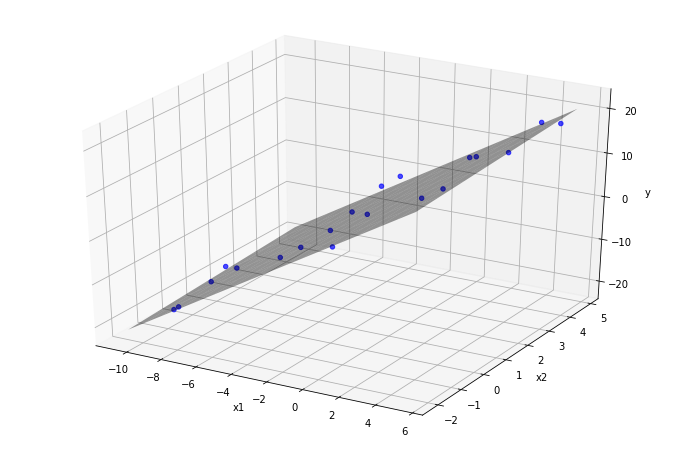

In [63]:
plot3Dscatter(data, 'x1', 'x2', lr, data['y'])

The regression coefficients are contained in the `coef_` attribute; the coefficients are the slopes of the projection of the plane of best fit onto the `x1-y`-plane and the `x2-y`-plane respectively.

In [64]:
lr.coef_

array([2.4586771 , 0.33546627])

Other estimators have parameters that must be passed into the constructor.

**Example:** A *k-nearest neighbor* regressor finds the makes predictions by averaging the y-values of the k-nearest examples to a given data point. The example below fixed the number of neighbors at 3:

In [66]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3)

After fitting the model, it predicts new possible outcomes on out-of-sample data:

In [97]:
knn.fit(X, y)
test_data = np.array([[1.0, 2.0]])
knn.predict(test_data)

array([8.87123925])

The prediction function is visualized as a function of two variables, alongside a scatter-plot of the training data. Every point on the surface is calculated by averaging the value of the nearest three data-points:

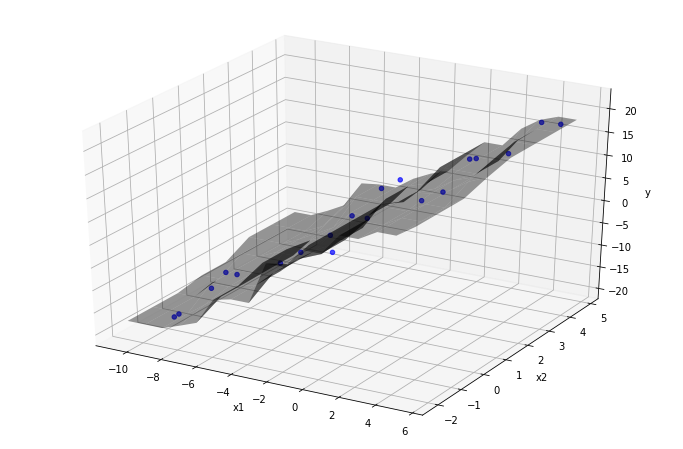

In [94]:
plot3Dscatter(data, 'x1', 'x2', knn, data['y'])

## Using Estimators in Scikit-Learn Pipelines

Scikit-learn pipelines may contain Estimators as the final step. As with pipelines composed of transformers, a pipeline containing an estimator is itself an estimator.

For example, calling `pl.fit(X, y)` on a pipeline `pl = Pipeline(steps)` containing an estimator roughly executes the following logic:

In [ ]:
out = X
for step in steps[:-1]:
    out = step.fit_transform(out)

step[-1].fit(out, y)

Similar logic applies to the `predict` and `score` methods.

**Example:** The dataset below contains home sales in Ames, Iowa compiled by [Dean De Cock](https://www.truman.edu/faculty-staff/decock/). The variables consist of a mixture of categorical and quantitative variables that describe the characteristics of each home in the dataset. A simple question one might ask:

> Can the price of the home sale be predicted from the characteristics of the house?

Approaching this question thoroughly is involved. This example merely constructs a basic pipeline with the following properties:

* Missing values in quantitative variables are imputed with the value `0`, then passed directly to the model without further feature engineering. Imputing with 0 is reasonable, as all quantitative columns with missing values represent positive quantities.
* Categorical variables are treated as nominal, imputed with the string `NULL`, then one-hot encoded. This attempt at feature engineering is a bare minimum and serves only as a baseline upon which to improve.
* The model chosen is a 'Decision Tree Regressor', which is well-suited to the features above.

In [168]:
# required imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

The housing data consists of 1460 observations (houses) and 81 attributes: one 'Id' column that identifies the distinct houses, the target variable 'SalePrice', and 79 features:

In [283]:
housing = pd.read_csv('data/housing.csv')
housing

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


Dropping the 'Id' field and removing the 'SalePrice' as the target variable:

In [134]:
X = housing.drop(['Id', 'SalePrice'], axis=1)
y = housing['SalePrice']

The categorical and quantitative columns are gathered into lists of column names:

In [154]:
types = X.dtypes
cat_cols = types.loc[types == np.object].index
quant_cols = types.loc[types != np.object].index

The pipeline described above is put together:

In [276]:
# categorical features
cat_process = (
    'cat_processing',
    Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='NULL')), 
        ('one-hot', OneHotEncoder())
    ]),
    cat_cols
)

# quantitative features
num_process = (
    'num_processing',
    SimpleImputer(strategy='constant', fill_value=0),
    quant_cols
)

ct = ColumnTransformer([cat_process, num_process])

# modeling pipeline
pl = Pipeline([('features', ct), ('regressor', DecisionTreeRegressor(max_depth=3))])

After fitting the pipeline, the RMSE can be calculated:

In [284]:
pl.fit(X, y)

preds = pl.predict(X)

np.sqrt(np.mean((preds - y)**2)) # RMSE

40142.374455005905